# Spectrogram Maker

## Liam Kelly

In [1]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import detrend
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

def my_spectrogram(x, s_rate, window_s = None, n_overlap = None, n_scale = 10, pad = True, pad_l = 10, trend = True, scale = 'log'):
    from scipy.fft import fft, fftfreq
    import numpy as np
    from scipy.signal import detrend
    
    # Initialize parameters:
    n_t =len(x) # Obtain the length of the time domain signal
    if window_s == None:
        window_s = int(n_t/50) # Choose the size of the window to perform Fourier transforms over
        print(window_s)
    if n_overlap == None:
        n_overlap = int(window_s*1/8) # chose the number of points to overlap between segments.
    step_size = window_s - n_overlap # Number of data points between FFT steps.
    n_FFTs = int((n_t-window_s)/step_size) # Total number of FFTs.
    
    # Perform FFT over each slice of time domain data:
    if pad == True:
        spect = np.zeros([int((window_s + 2*pad_l)/2), n_FFTs]) # Initialize the spectrogram array.
    if pad == False:
        spect = np.zeros([int(window_s/2), n_FFTs]) # Initialize the spectrogram array.
    for i in range(n_FFTs):
        x_c = x[i*step_size: i*step_size + window_s] # Slice out data for the current FFT.
        
        # Detrend the data to prevent computational artifacts near low frequencies:
        if trend == True:
            x_c = detrend(x_c)
            
        # Linear scale first and last values to prevent delta function:
        x_c[:n_scale] = x_c[:n_scale]*np.linspace(0,1,n_scale)
        x_c[-n_scale:] = x_c[-n_scale:]*np.linspace(1,0,n_scale)
        
        if pad == True:
            x_c = np.pad(x_c, pad_l, mode = 'constant') 
        n = len(x_c)
        
        # Perform the FFT on the current slice
        X_c = 2/n * (np.abs(fft(x_c)[:n//2]))
        if scale == 'log':
            X_c = 10*np.log10(X_c)
        spect[:,i] = X_c
        
    return spect

(135, 71)


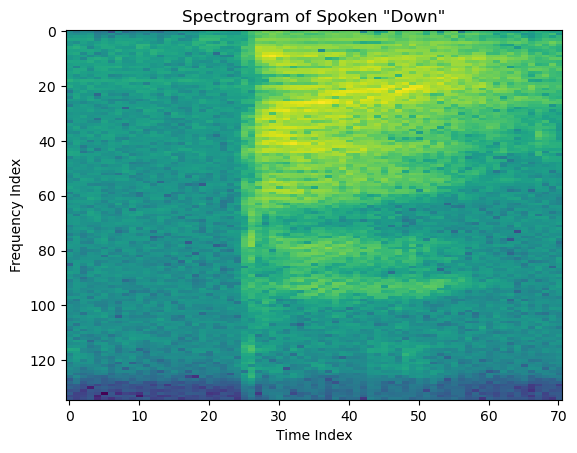

(129, 71)


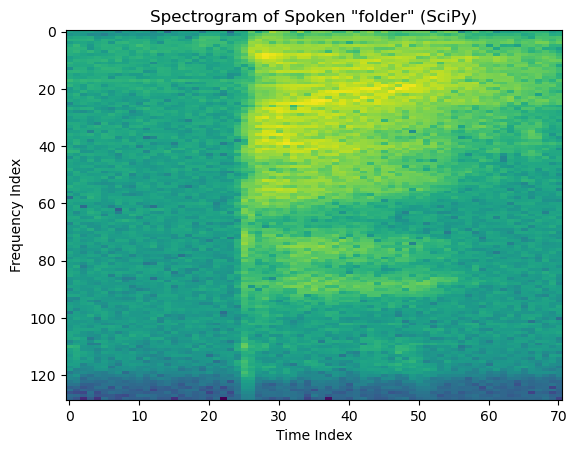

In [2]:
# Test my function and compare with the scipy function:
s_rate, data = wavfile.read('data/down/00b01445_nohash_1.wav')
t = np.arange(len(data))/s_rate
spec = my_spectrogram(data, s_rate, window_s = 250, n_scale = 50)

print(spec.shape)
plt.imshow(spec, cmap='viridis', aspect = 'auto', interpolation = 'nearest')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
plt.title('Spectrogram of Spoken "Down"')
plt.show()  

x= spectrogram(data, s_rate, mode = 'magnitude')
print(x[2].shape)
plt.imshow(np.log(x[2]), cmap='viridis', interpolation='nearest', aspect = 'auto')
plt.title('Spectrogram of Spoken "%s" (SciPy)' % 'folder')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
plt.show()

    

In [7]:
# For loop over each file in data folder:
folder= 'data/'
j=1
for subfolder in os.listdir(folder):
    
    path = folder + subfolder + '/'
    print('Currently processing the \033[1m%s\033[0m subfolder... (%i/%i)        ' % (subfolder, j, len(os.listdir(folder))), end = '\r')
    j += 1
    
    for item in os.listdir(path):
        # Load the data
        s_rate, x = wavfile.read(path + item)
        spec = my_spectrogram(x, s_rate, window_s = 250, n_scale = 50)
        np.save('spectrogram/' + subfolder + '/' + item[:-4], spec)  
        
print('Done!                                                  ', end = '\r')      

C:\Users\liamg\AppData\Local\Temp\ipykernel_2888\894052206.py:47: RuntimeWarning: divide by zero encountered in log10
  X_c = 10*np.log10(X_c)
